## 기본 입력사항

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import *

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# 한글 폰트
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = True

# 나눔 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
# 폰트확인
print(plt.rcParams['font.family'], plt.rcParams['font.size'])

Selecting previously unselected package fonts-nanum.
(Reading database ... 124950 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
['NanumGothic'] 10.0


In [3]:
# mosaic plot
from statsmodels.graphics.mosaicplot import mosaic

# scipy 가설 검정 도구
import scipy.stats as spst

In [15]:
# 데이터 로드
data = pd.read_csv('/content/location_tourism_expanded0115.csv')

In [16]:
# EDA용 함수 정의
target = '관광활성화 지수'

# 수치 단변량 EDA : 기초통계량, histogram, boxplot
def eda_1_n(feature, data=data, bins = 30) :
    # 기초 통계량
    display(data[[feature]].describe().T)

    # 시각화
    print(f'{feature} 단변량 시각화')
    # histogram
    plt.figure(figsize = (8,4))
    plt.subplot(2,1,1)
    sns.histplot(data[feature], bins = bins, kde = True)
    plt.grid()

    # boxplot
    plt.subplot(2,1,2)
    sns.boxplot(x = data[feature])
    plt.grid()
    plt.tight_layout()
    plt.show()

# 범주 단변량 EDA : 기초통계량, countplot, pieplot
def eda_1_c(feature, data=data) :
    # 기초 통계량
    print(f'{feature}의 범주, 양, 비율')
    cnt = data[feature].value_counts()
    ratio = data[feature].value_counts(normalize=True)
    temp = pd.DataFrame({'Class':cnt.index, 'Count':cnt.values, 'Ratio':ratio.values})
    display(temp)

    # 시각화
    print(f'{feature} 단변량 시각화')
    # countplot
    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    sns.countplot(x = feature, data = data)
    plt.grid()

    # pieplot
    temp2 = data[feature].value_counts()
    explode = [0.03 for i in range(len(temp.index))]
    plt.subplot(1, 2, 2)
    plt.pie(temp2.values, labels = temp2.index, autopct = '%.2f%%',
        startangle=90, counterclock=False,
        explode = explode, shadow=True)
    plt.tight_layout()
    plt.show()

# 수치 - 수치 EDA : scatterplot, regplot, 상관분석
def eda_2_nn(feature, target=target, data=data):
    # scatterplot, regplot 생성
    print(f'{feature} - {target}의 상관관계 시각화')
    temp = data.loc[data[feature].notnull()]
    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    sns.scatterplot(data = temp, x=feature, y=target)
    plt.subplot(1, 2, 2)
    sns.regplot(data = temp, x=feature, y=target)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # 구분선
    print('='*100)

    # 상관분석 실시
    print(f'{feature} - {target}의 상관분석 결과')
    result = spst.pearsonr(temp[feature], temp[target])
    print(f'상관계수 : {result[0]}')
    print(f'p-value : {result[1]}')

# 범주 - 수치 EDA : barplot, t-test, ANOVA
def eda_2_cn(feature, target=target, data=data):
    temp = data.loc[data[feature].notnull()]
    # barplot 생성
    print(f'{feature} - {target}의 상관관계 시각화')
    plt.figure(figsize=(5,5))
    sns.barplot(x = feature, y = target, data = temp)
    plt.grid()
    plt.show()

    # 구분선
    print('='*100)

    # feature의 범주들에 따른 target 데이터를 cats에 담기
    cats = []
    for i in temp[feature].unique() :
        cats.append(data.loc[temp[feature] == i, target])

    # 범주 수에 따라 t-test 또는 ANOVA 진행
    if len(cats) == 2:
        # t-test
        t_stat, p_value = spst.ttest_ind(cats[0], cats[1])
        print(f"T-test 결과: t-statistic = {t_stat}, p-value = {p_value}")

    elif len(cats) > 2:
        # ANOVA
        f_stat, p_value = spst.f_oneway(*cats)
        print(f"ANOVA 결과: F-statistic = {f_stat}, p-value = {p_value}")

    else:
        print("비교할 그룹이 부족합니다.") # 범주형 컬럼의 값이 없거나 하나뿐일 때

In [17]:
# 기본 확인
data.isna().sum()

,0
지역명,0
인구수,0
관광지수,0
음식시설수,0
쇼핑센터수,0
관광활성화 지수,0
의료시설 수,0
숙박객실수,0
연평균소득(천원),0
대기오염도,0


In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
인구수,247.0,179054.425101,150653.106642,5587.00,44278.000,149608.00,270287.0,790670.00
관광지수,247.0,196.408907,196.281444,28.00,104.000,152.00,220.5,1760.00
음식시설수,247.0,3786.352227,2740.516982,252.00,1248.500,3472.00,5422.0,14631.00
쇼핑센터수,247.0,33.364372,20.351505,4.00,19.000,29.00,45.0,142.00
관광활성화 지수,247.0,49.395992,22.291887,4.33,31.865,48.97,66.7,95.41
의료시설 수,247.0,145.255061,160.050360,1.00,33.000,116.00,209.0,1743.00
숙박객실수,247.0,3374.287449,3334.985592,22.00,1334.500,2308.00,4376.5,26893.00
연평균소득(천원),247.0,36102.275304,4438.010672,31062.00,33308.000,34914.00,37616.0,61913.00
대기오염도,247.0,35.639312,4.592844,24.25,31.420,35.83,39.0,46.67
주차장면수,247.0,2553.481781,2848.845383,6.00,875.500,1675.00,2822.5,17226.00


In [19]:
data.head()

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수
0,강원특별자치도 강릉시,179318,472,5648,50,79.80,124.0,12817.0,35014.0,30.25,3374.0
1,강원특별자치도 고성군,21270,154,913,8,46.67,7.0,4960.0,31875.0,28.74,354.0
2,강원특별자치도 동해시,72280,126,2334,19,41.54,55.0,3345.0,35199.0,32.92,1303.0
3,강원특별자치도 삼척시,46205,201,1741,20,46.06,31.0,2534.0,33784.0,27.42,366.0
4,강원특별자치도 속초시,66912,145,3057,19,69.24,69.0,16188.0,34639.0,34.17,11648.0


## (추가)의료미충족율을 달아보자

In [21]:
df_med = pd.read_csv('/content/23년 의료미충족율 표준화 지수.csv')
df_med = df_med.loc[(df_med['시도'] != '제주특별자치도') & (df_med['시군구'] != '소계')]
df_med['지역명'] = df_med['시도'] + ' ' + df_med['시군구']
df_med = df_med.drop(['시도', '시군구'], axis=1)
df_med = df_med.rename(columns={'표준화율 (%)':'의료미충족율'})
df_med

,의료미충족율,지역명
1,3.3,서울특별시 강남구
2,4.0,서울특별시 강동구
3,4.9,서울특별시 강북구
4,3.3,서울특별시 강서구
5,4.5,서울특별시 관악구
...,...,...
240,5.6,경상남도 통영시
241,7.7,경상남도 하동군
242,11.3,경상남도 함안군
243,7.7,경상남도 함양군


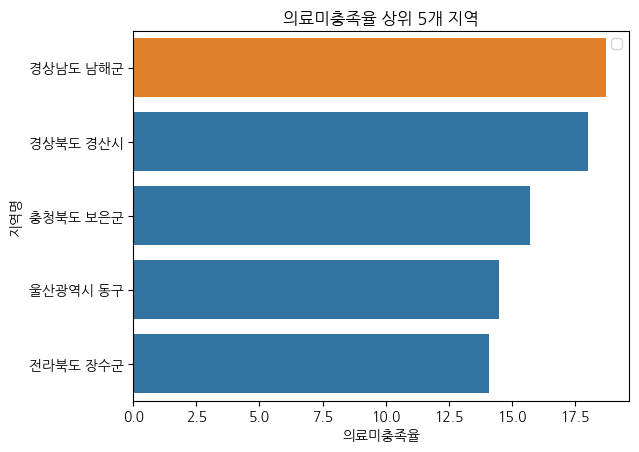

In [22]:
temp = df_med.sort_values(by='의료미충족율', ascending=False).reset_index(drop=True)
temp2 = temp.iloc[:5, :]
# 남해군이 의료미충족율 1위임을 보여주는 시각화
sns.barplot(data=temp2, x='의료미충족율', y='지역명', orient='h',hue=temp['지역명'] == '경상남도 남해군')
plt.title('의료미충족율 상위 5개 지역')
plt.legend('')
plt.show()

In [23]:
# 전라북도 변경
df_med['지역명'] = df_med['지역명'].str.replace('전라북도', '전북특별자치도')
df_med['지역명'].unique()



array(['서울특별시 강남구', '서울특별시 강동구', '서울특별시 강북구', '서울특별시 강서구', '서울특별시 관악구',
       '서울특별시 광진구', '서울특별시 구로구', '서울특별시 금천구', '서울특별시 노원구', '서울특별시 도봉구',
       '서울특별시 동대문구', '서울특별시 동작구', '서울특별시 마포구', '서울특별시 서대문구', '서울특별시 서초구',
       '서울특별시 성동구', '서울특별시 성북구', '서울특별시 송파구', '서울특별시 양천구', '서울특별시 영등포구',
       '서울특별시 용산구', '서울특별시 은평구', '서울특별시 종로구', '서울특별시 중구', '서울특별시 중랑구',
       '부산광역시 강서구', '부산광역시 금정구', '부산광역시 기장군', '부산광역시 남구', '부산광역시 동구',
       '부산광역시 동래구', '부산광역시 부산진구', '부산광역시 북구', '부산광역시 사상구', '부산광역시 사하구',
       '부산광역시 서구', '부산광역시 수영구', '부산광역시 연제구', '부산광역시 영도구', '부산광역시 중구',
       '부산광역시 해운대구', '대구광역시 남구', '대구광역시 달서구', '대구광역시 달성군', '대구광역시 동구',
       '대구광역시 북구', '대구광역시 서구', '대구광역시 수성구', '대구광역시 중구', '대구광역시 군위군',
       '인천광역시 강화군', '인천광역시 계양구', '인천광역시 미추홀구', '인천광역시 남동구', '인천광역시 동구',
       '인천광역시 부평구', '인천광역시 서구', '인천광역시 연수구', '인천광역시 옹진군', '인천광역시 중구',
       '광주광역시 광산구', '광주광역시 남구', '광주광역시 동구', '광주광역시 북구', '광주광역시 서구',
       '대전광역시 대덕구', '대전광역시 동구', '대전광역시 서구', '대전광역시 유성구', '대전광역시 중구',
       

In [24]:
data['의료미충족율'] = None

for idx, row in data.iterrows():
    # 시 이름 추출
    시_이름 = data.loc[idx, '지역명'].split()[0] + ' ' + data.loc[idx, '지역명'].split()[1]

    # df_med에서 '의료미충족율' 값 추출
    시_의료미충족율 = df_med.loc[df_med['지역명'] == 시_이름, '의료미충족율'].values

    # 값이 존재하면 '의료미충족율' 컬럼에 할당
    if len(시_의료미충족율) > 0:
        data.loc[idx, '의료미충족율'] = 시_의료미충족율[0]


# 결과 확인
data

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
0,강원특별자치도 강릉시,179318,472,5648,50,79.80,124.0,12817.0,35014.0,30.25,3374.0,7.4
1,강원특별자치도 고성군,21270,154,913,8,46.67,7.0,4960.0,31875.0,28.74,354.0,2.4
2,강원특별자치도 동해시,72280,126,2334,19,41.54,55.0,3345.0,35199.0,32.92,1303.0,3.6
3,강원특별자치도 삼척시,46205,201,1741,20,46.06,31.0,2534.0,33784.0,27.42,366.0,4.6
4,강원특별자치도 속초시,66912,145,3057,19,69.24,69.0,16188.0,34639.0,34.17,11648.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
242,충청북도 청주시 상당구,157184,231,4331,31,48.18,136.0,2356.0,36643.0,40.50,7.0,7.9
243,충청북도 청주시 서원구,172514,83,4108,31,42.22,136.0,813.0,36276.0,40.50,7.0,7.9
244,충청북도 청주시 청원구,168871,93,4521,47,53.54,136.0,4654.0,37929.0,40.50,7.0,7.9
245,충청북도 청주시 흥덕구,232581,95,6347,50,65.43,136.0,4706.0,39687.0,40.50,7.0,7.9


## EDA

In [25]:
data.columns

Index(['지역명', '인구수', '관광지수', '음식시설수', '쇼핑센터수', '관광활성화 지수', '의료시설 수', '숙박객실수',
       '연평균소득(천원)', '대기오염도', '주차장면수', '의료미충족율'],
      dtype='object')

인구수 - 관광활성화 지수의 상관관계 시각화


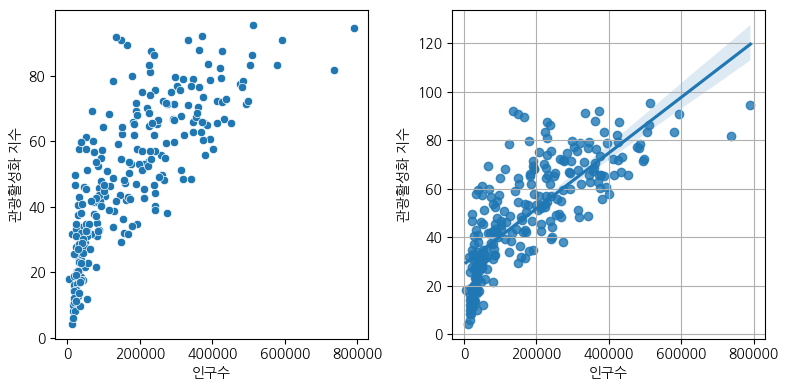

인구수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.7749428463384569
p-value : 9.941198141118663e-51


관광지수 - 관광활성화 지수의 상관관계 시각화


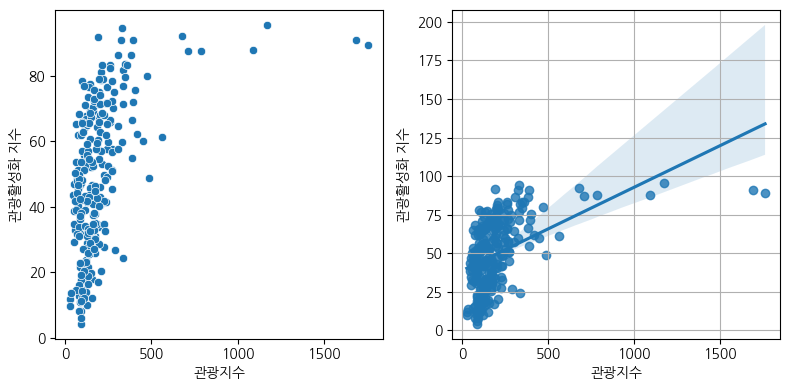

관광지수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.4758969197638703
p-value : 2.2987891788250206e-15


음식시설수 - 관광활성화 지수의 상관관계 시각화


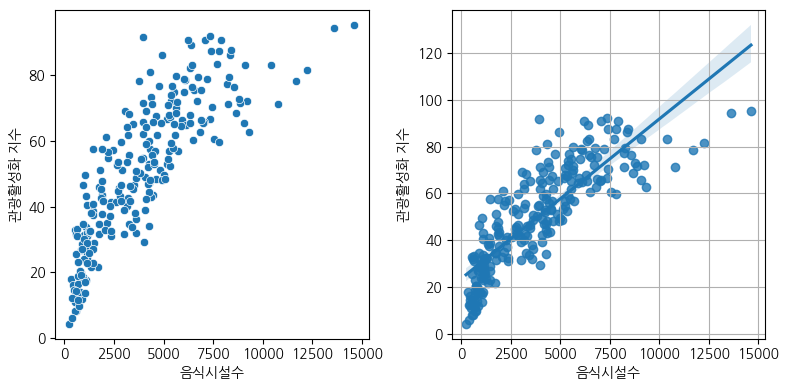

음식시설수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.8390013740824789
p-value : 1.070119004197848e-66


쇼핑센터수 - 관광활성화 지수의 상관관계 시각화


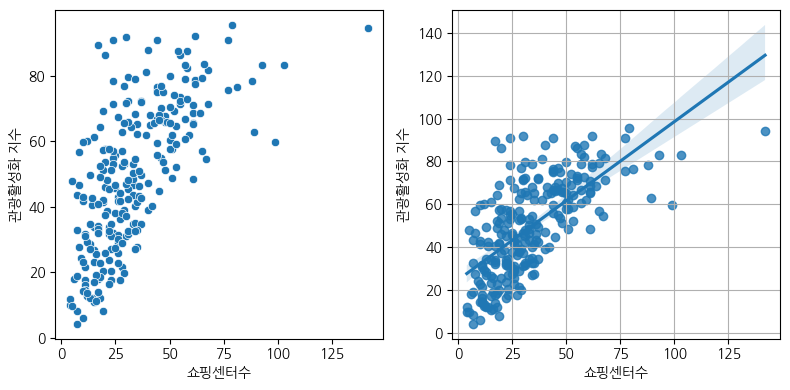

쇼핑센터수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.6731832323344288
p-value : 5.794869915731702e-34


의료시설 수 - 관광활성화 지수의 상관관계 시각화


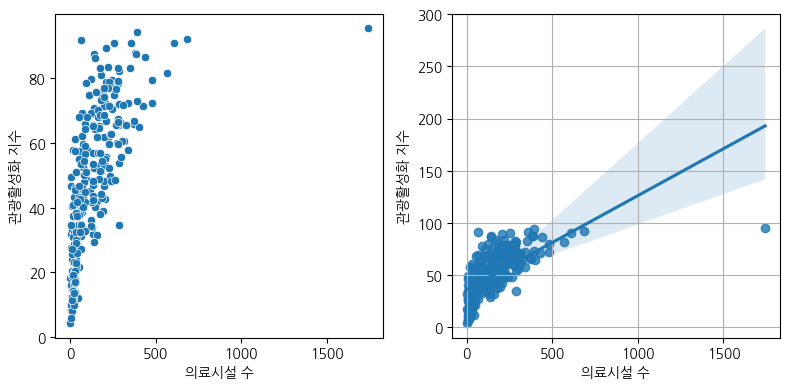

의료시설 수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.645044758413258
p-value : 1.8746753633561696e-30


숙박객실수 - 관광활성화 지수의 상관관계 시각화


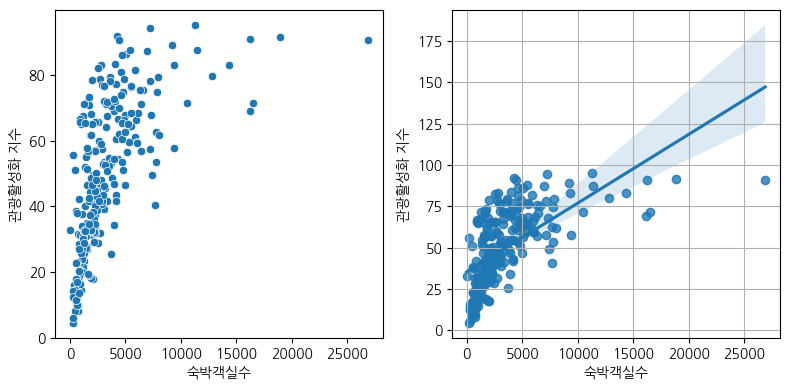

숙박객실수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.6219230352366516
p-value : 7.811131376103523e-28


연평균소득(천원) - 관광활성화 지수의 상관관계 시각화


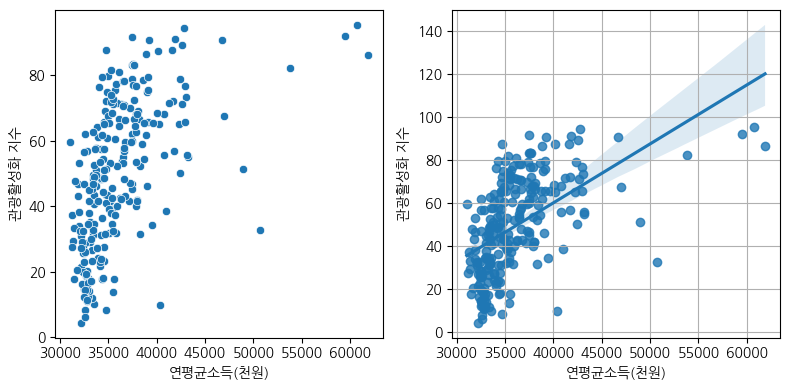

연평균소득(천원) - 관광활성화 지수의 상관분석 결과
상관계수 : 0.5454087161303554
p-value : 1.5224039810591652e-20


대기오염도 - 관광활성화 지수의 상관관계 시각화


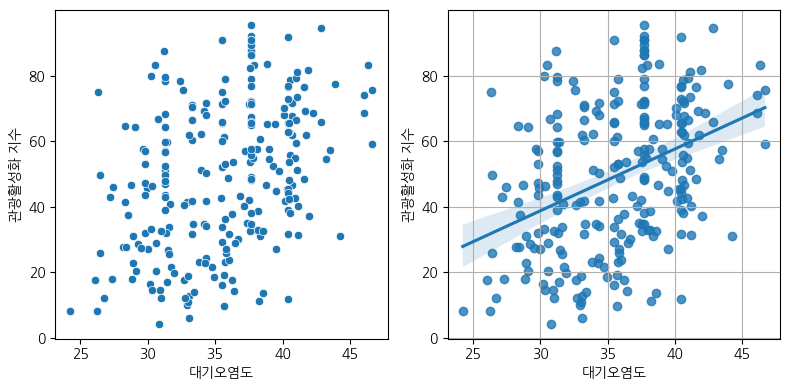

대기오염도 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.38874590866666925
p-value : 2.462263550005513e-10


주차장면수 - 관광활성화 지수의 상관관계 시각화


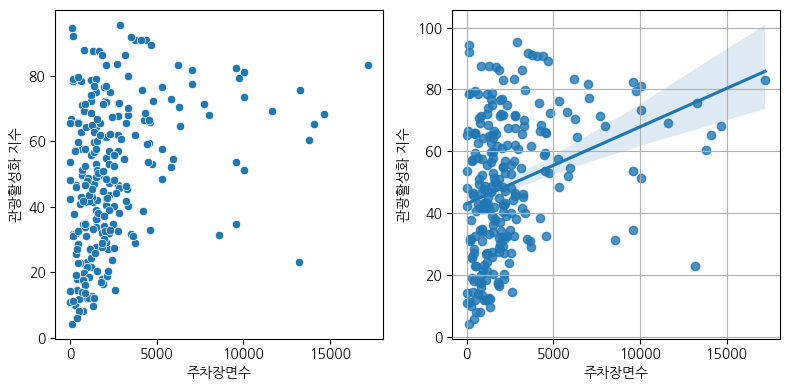

주차장면수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.3176895963426811
p-value : 3.391173731861017e-07




In [26]:
# 상관관계분석
n_cols = ['인구수', '관광지수', '음식시설수', '쇼핑센터수', '의료시설 수', '숙박객실수', '연평균소득(천원)', '대기오염도', '주차장면수']

for col in n_cols:
  eda_2_nn(col)
  print()
  print()

In [27]:
data.loc[data['지역명']=='경상남도 남해군']

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
64,경상남도 남해군,32600,201,1107,26,43.12,25.0,2057.0,31841.0,27.17,1242.0,18.7


In [28]:
data.sort_values(by='숙박객실수', ascending=False).iloc[:13]

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
163,서울특별시 중구,149384,1687,6225,24,90.79,255.0,26893.0,39267.0,37.67,4089.0,2.3
179,인천광역시 중구,135044,189,3947,30,91.80,65.0,18901.0,37453.0,40.42,3519.0,4.8
165,울산광역시 남구,272828,243,8861,30,71.66,312.0,16532.0,41266.0,34.33,2814.0,3.8
139,부산광역시 해운대구,333518,326,7083,44,90.97,357.0,16226.0,41868.0,35.50,3762.0,3.5
4,강원특별자치도 속초시,66912,145,3057,19,69.24,69.0,16188.0,34639.0,34.17,11648.0,3.0
192,전라남도 여수시,224870,359,6444,57,83.29,173.0,14342.0,37664.0,30.50,6209.0,6.1
0,강원특별자치도 강릉시,179318,472,5648,50,79.80,124.0,12817.0,35014.0,30.25,3374.0,7.4
83,경상북도 경주시,229661,786,7403,58,87.61,141.0,11436.0,34754.0,31.17,1299.0,5.8
140,서울특별시 강남구,512111,1171,14631,79,95.41,1743.0,11314.0,60716.0,37.67,2897.0,3.3
37,경기도 수원시 팔달구,189630,237,3981,30,71.49,201.0,10525.0,35906.0,40.67,2799.0,5.6


,count,mean,std,min,25%,50%,75%,max
인구수,247.0,179054.425101,150653.106642,5587.0,44278.0,149608.0,270287.0,790670.0


인구수 단변량 시각화


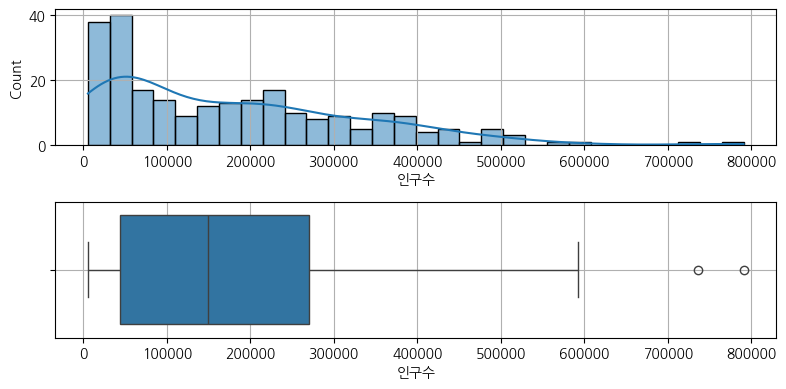

,count,mean,std,min,25%,50%,75%,max
관광지수,247.0,196.408907,196.281444,28.0,104.0,152.0,220.5,1760.0


관광지수 단변량 시각화


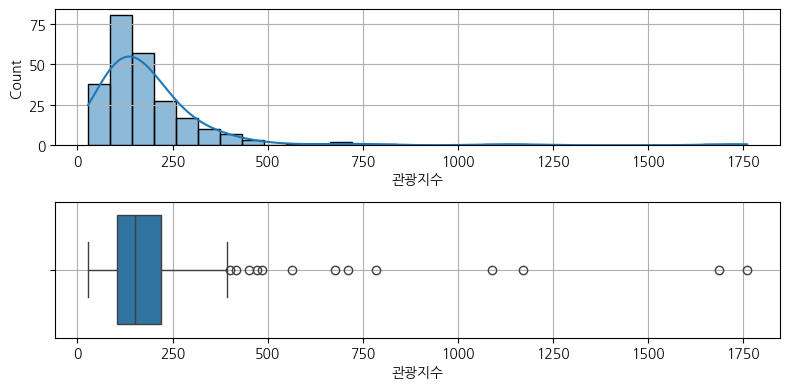

,count,mean,std,min,25%,50%,75%,max
음식시설수,247.0,3786.352227,2740.516982,252.0,1248.5,3472.0,5422.0,14631.0


음식시설수 단변량 시각화


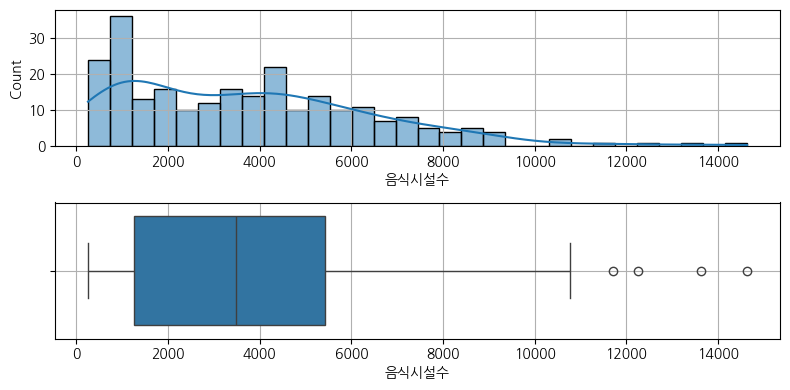

,count,mean,std,min,25%,50%,75%,max
쇼핑센터수,247.0,33.364372,20.351505,4.0,19.0,29.0,45.0,142.0


쇼핑센터수 단변량 시각화


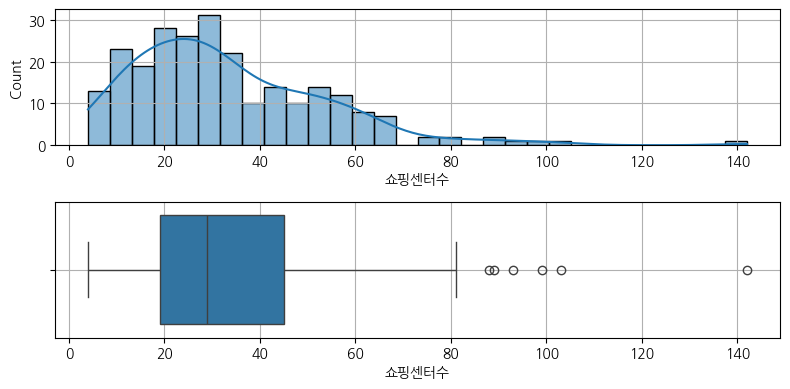

,count,mean,std,min,25%,50%,75%,max
의료시설 수,247.0,145.255061,160.05036,1.0,33.0,116.0,209.0,1743.0


의료시설 수 단변량 시각화


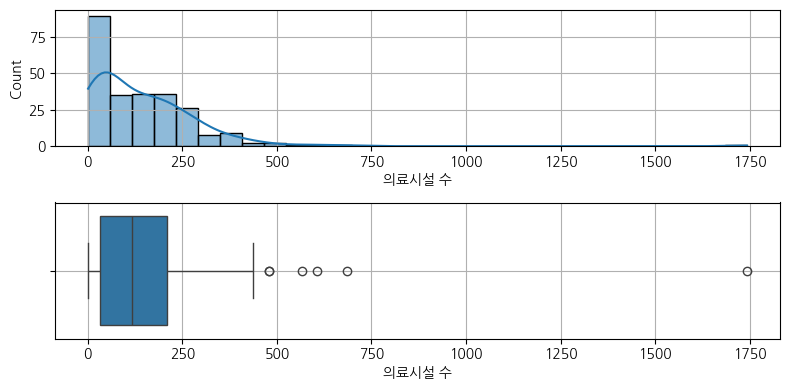

,count,mean,std,min,25%,50%,75%,max
숙박객실수,247.0,3374.287449,3334.985592,22.0,1334.5,2308.0,4376.5,26893.0


숙박객실수 단변량 시각화


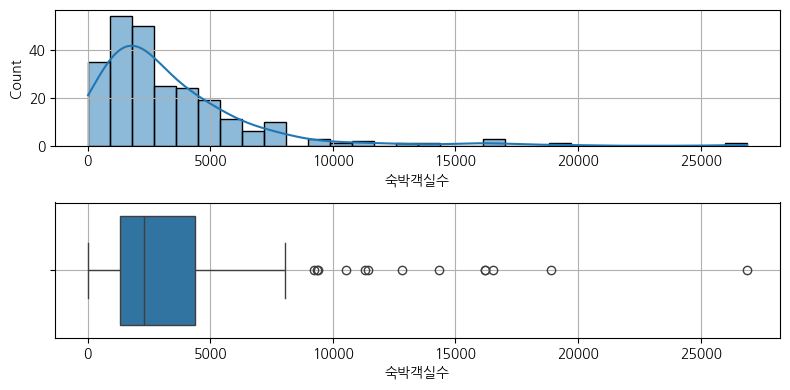

,count,mean,std,min,25%,50%,75%,max
연평균소득(천원),247.0,36102.275304,4438.010672,31062.0,33308.0,34914.0,37616.0,61913.0


연평균소득(천원) 단변량 시각화


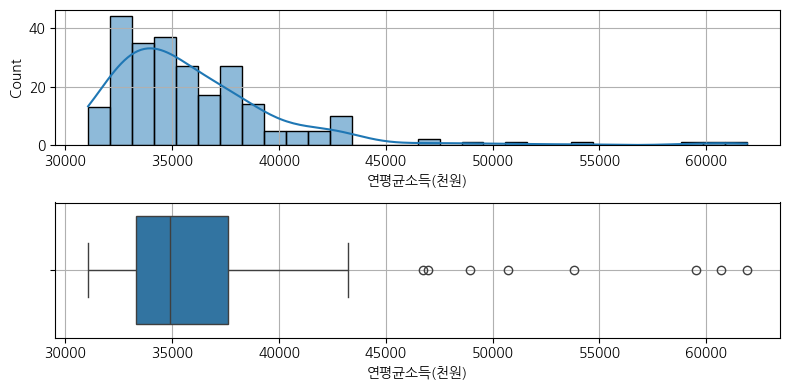

,count,mean,std,min,25%,50%,75%,max
대기오염도,247.0,35.639312,4.592844,24.25,31.42,35.83,39.0,46.67


대기오염도 단변량 시각화


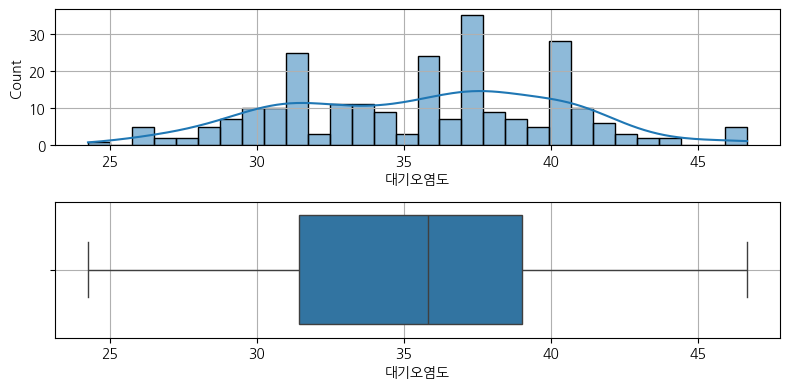

,count,mean,std,min,25%,50%,75%,max
주차장면수,247.0,2553.481781,2848.845383,6.0,875.5,1675.0,2822.5,17226.0


주차장면수 단변량 시각화


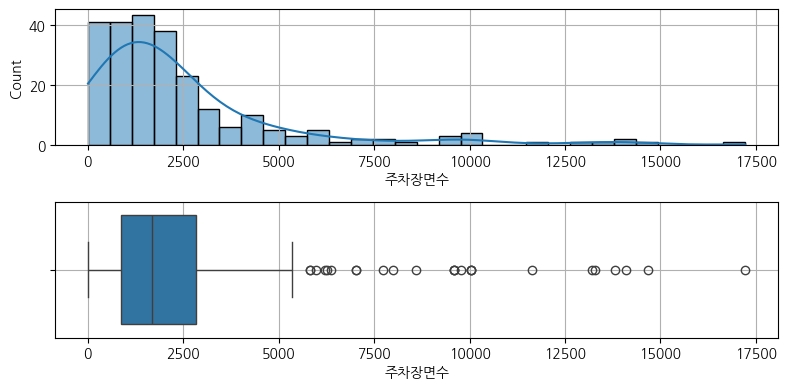

In [29]:
# 단변량분석
for col in n_cols:
  eda_1_n(col)
  print()
  print()

In [30]:
data.loc[data['의료시설 수'] > 500]

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
30,경기도 부천시,735736,337,12257,68,81.71,566.0,5884.0,35334.0,41.92,7027.0,5.7
140,서울특별시 강남구,512111,1171,14631,79,95.41,1743.0,11314.0,60716.0,37.67,2897.0,3.3
154,서울특별시 서초구,371863,677,7364,62,92.06,685.0,4263.0,59544.0,37.67,163.0,2.2
157,서울특별시 송파구,592985,391,7907,77,90.81,607.0,4430.0,46730.0,37.67,4389.0,4.4


의료시설 수 - 관광활성화 지수의 상관관계 시각화


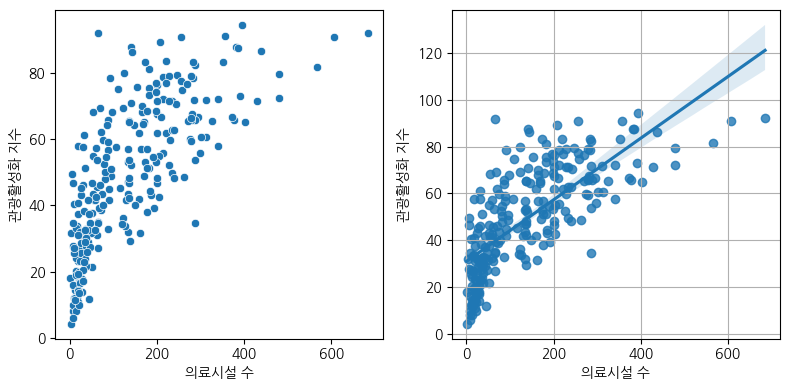

의료시설 수 - 관광활성화 지수의 상관분석 결과
상관계수 : 0.7346953694604328
p-value : 5.275970519677213e-43


In [31]:
temp = data.loc[data['지역명'] != '서울특별시 강남구']
eda_2_nn('의료시설 수', data=temp)

,count,mean,std,min,25%,50%,75%,max
의료시설 수,246.0,138.760163,123.526397,1.0,33.0,113.0,207.0,685.0


의료시설 수 단변량 시각화


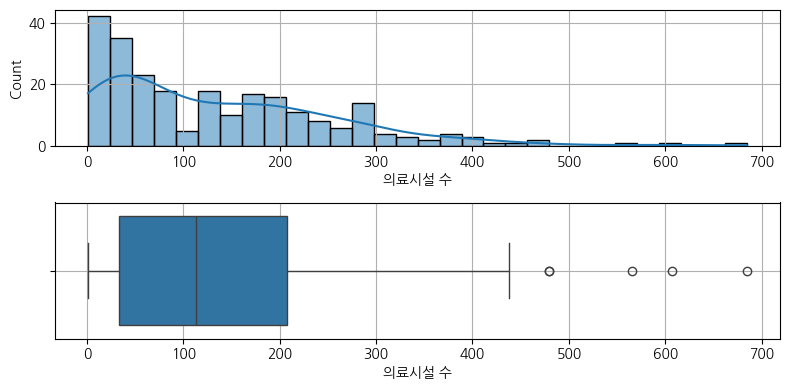

In [32]:
eda_1_n('의료시설 수', data=temp)

In [33]:
temp.sort_values(by='의료시설 수', ascending=False).iloc[:5]

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
154,서울특별시 서초구,371863,677,7364,62,92.06,685.0,4263.0,59544.0,37.67,163.0,2.2
157,서울특별시 송파구,592985,391,7907,77,90.81,607.0,4430.0,46730.0,37.67,4389.0,4.4
30,경기도 부천시,735736,337,12257,68,81.71,566.0,5884.0,35334.0,41.92,7027.0,5.7
121,대전광역시 서구,411848,270,9223,55,72.32,479.0,4078.0,37716.0,35.75,4806.0,1.5
130,부산광역시 부산진구,297762,349,8281,31,79.55,479.0,7923.0,34316.0,31.25,475.0,6.0


In [34]:
temp.loc[temp['지역명']=='경상남도 남해군']

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
64,경상남도 남해군,32600,201,1107,26,43.12,25.0,2057.0,31841.0,27.17,1242.0,18.7


In [35]:
# 남해군의 관광활성화 지수 추출
namhae_tourism = temp.loc[temp['지역명'] == '경상남도 남해군', '관광활성화 지수'].values[0]

# 유사한 관광활성화 지수를 가진 지역 필터링
similar = data.loc[
    (data['관광활성화 지수'] > namhae_tourism * 0.98) &
    (data['관광활성화 지수'] < namhae_tourism * 1.02)
]
similar.sort_values(by='관광활성화 지수', ascending=False)


,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
134,부산광역시 서구,86366,45,1912,7,43.44,74.0,2970.0,33509.0,31.25,1125.0,2.5
72,경상남도 창원시 마산합포구,144062,137,4486,33,43.43,134.0,4173.0,34792.0,29.83,2224.0,8.8
102,경상북도 칠곡군,103076,113,2810,36,43.29,53.0,2071.0,34899.0,36.83,1026.0,3.7
64,경상남도 남해군,32600,201,1107,26,43.12,25.0,2057.0,31841.0,27.17,1242.0,18.7
136,부산광역시 연제구,168682,135,4345,10,43.01,186.0,2419.0,36741.0,31.25,641.0,5.2
43,경기도 안양시 만안구,211555,72,3205,14,42.63,204.0,2572.0,36262.0,40.92,2079.0,4.3
209,전북특별자치도 완주군,78727,182,1842,37,42.62,60.0,1690.0,35415.0,35.42,2152.0,1.7


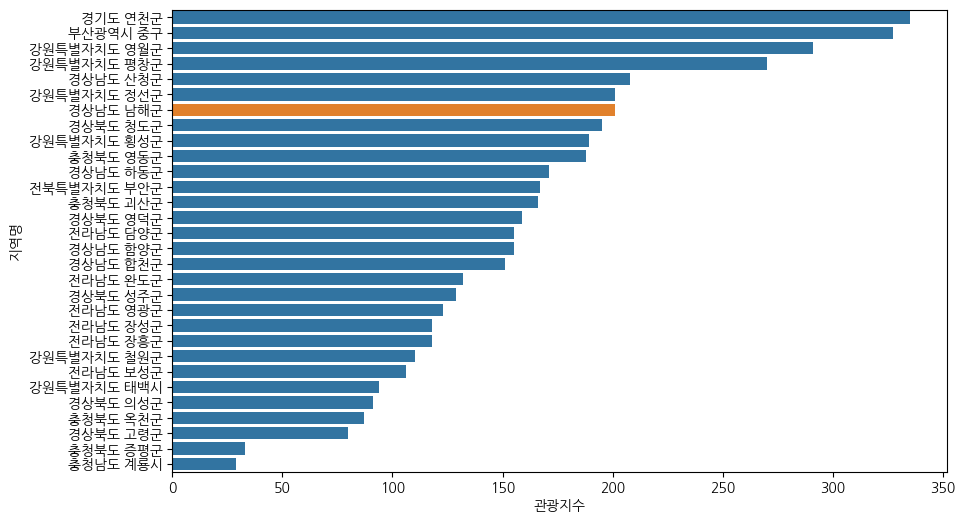

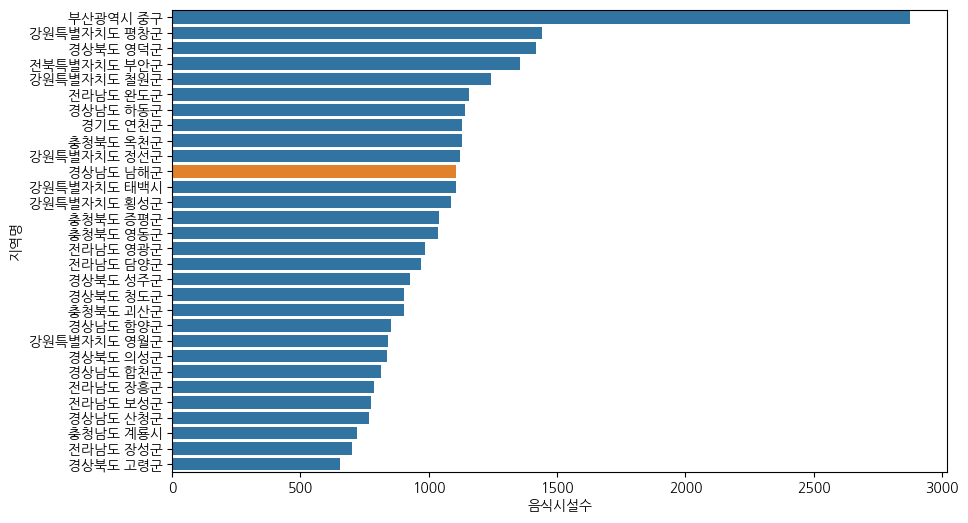

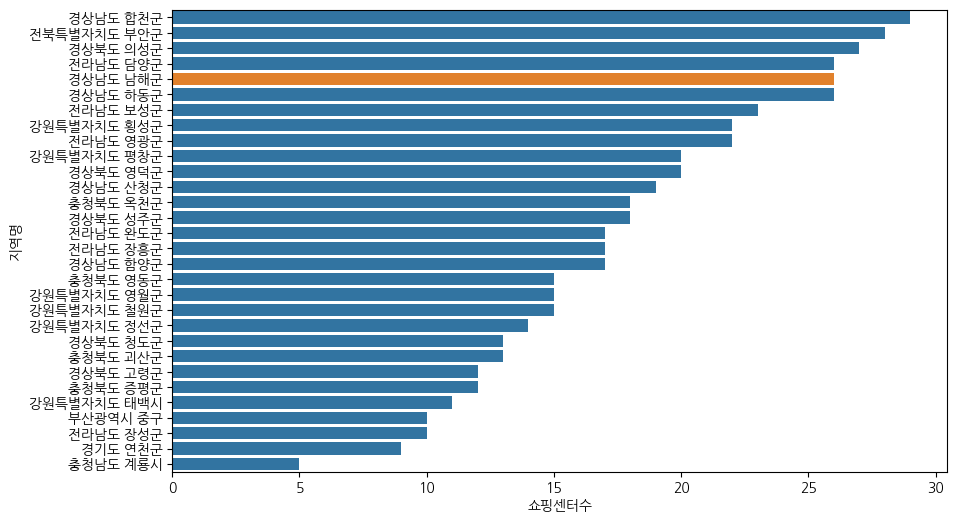

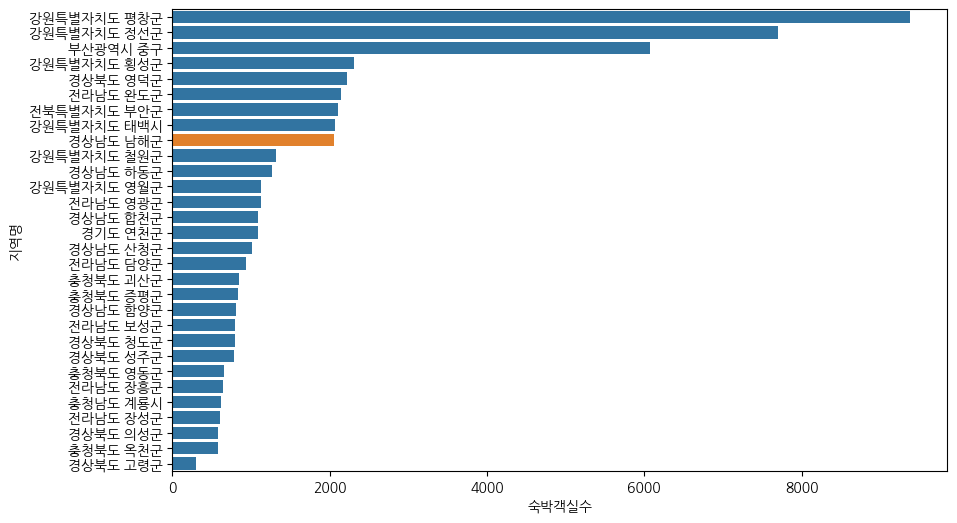

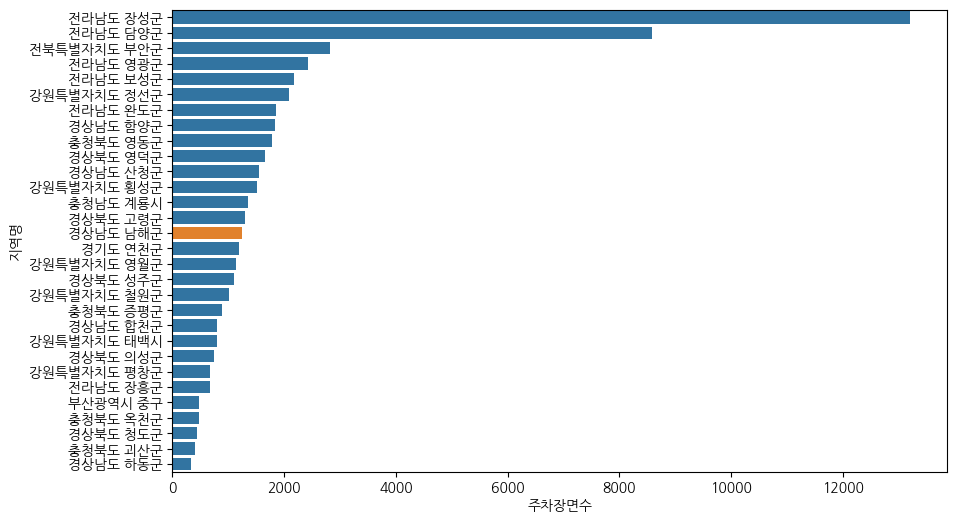

In [36]:
# 남해군과 인구수가 비슷한 곳들의 시설 수 시각화
namhae_population = data.loc[data['지역명'] == '경상남도 남해군', '인구수'].values[0]

for col in ['관광지수', '음식시설수', '쇼핑센터수', '숙박객실수', '주차장면수']:
  regions = data.loc[
    (data['인구수'] > namhae_population * 0.8) &
    (data['인구수'] < namhae_population * 1.2)
    ].sort_values(by=col, ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(
      data=regions,
      x=col, y='지역명', orient='h',
      hue=regions['지역명'] == '경상남도 남해군',
      order=regions.sort_values(by=col, ascending=False)['지역명']
  )
  plt.legend([], [], frameon=False)
  plt.show()


## 전처리

In [37]:
# 전처리 필요 변수 선언
target = '관광활성화 지수'               # target 선언(필수)
drop_cols = ['지역명']            # 제거할 열 선언(선택)
dumm_cols = []            # 가변수화할 열 선언(선택)
labelencoding = False     # 원핫 인코딩 대신 라벨 인코딩 할거라면 True 입력
scaler = StandardScaler()   # StandardScaler()로 변경 가능, 대상 데이터가 없으면 None
strat = False             # 분류 문제에서는 True 입력(stratify=y 옵션)

In [38]:
# 데이터 전처리
def ml_pre(data):
    # 전역변수 설정
    global X, y, X_train, y_train

    # 컬럼 제거
    if drop_cols:
        data = data.drop(drop_cols, axis=1)

    # x, y 분리
    X = data.drop(target, axis=1)
    y = data[target]

    # 가변수화
    if dumm_cols:
        # 라벨인코딩
        if labelencoding:
            le = LabelEncoder()
            for col in dumm_cols:
                if X[col].dtypes != object:
                    X[col] = X[col].astype(object)
                X[col] = le.fit_transform(X[col])
        # 원핫인코딩
        else:
            X = pd.get_dummies(X, columns=dumm_cols, drop_first=True, dtype=int)

    # train_test_split
    if strat:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # 스케일링
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    else:
        pass

    # 전처리 결과 출력
    print('<전처리 결과>')
    print()
    print('X_train 상위 5행')
    display(pd.DataFrame(X_train).head())
    if drop_cols:
        print(f'제거된 열: {drop_cols}')
    if dumm_cols:
        print(f'가변수화된 열: {dumm_cols}')
        if labelencoding:
            print('가변수화 방법: Label Encoding')
        else:
            print('가변수화 방법: One-Hot Encoding')
    if scaler:
        print(f'스케일링: {scaler}')

    # y가 문자면 LabelEncoding을 통해 int로 바꾸기
    if y_train.dtype == 'object':
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)
        print('Target이 범주화되었습니다.')
        display(f'{y_train[:20]}...')


In [39]:
# 강남구 빼보기
data_drop = data.loc[data['지역명'] != '서울특별시 강남구']

In [40]:
ml_pre(data_drop)

<전처리 결과>

X_train 상위 5행


,0,1,2,3,4,5,6,7,8,9
0,0.730817,0.251584,1.434463,3.107108,0.711221,0.571240,0.185082,-0.935186,-0.406630,1.920401
1,0.203532,-0.615947,-0.206831,-0.906492,0.511974,-0.230225,0.065015,1.128245,-0.156749,-0.577026
2,0.727820,0.940652,1.108205,0.557292,1.101747,0.434930,0.164684,1.145621,0.721763,1.077114
3,0.616752,0.018590,0.235207,-0.434303,0.703251,-0.597743,1.545912,0.422334,-0.221361,-1.063537
4,0.392906,-0.482100,0.692968,1.501668,0.193178,-0.330588,-0.738595,0.331109,0.084208,3.866448


제거된 열: ['지역명']
스케일링: StandardScaler()


,Feature,Importance
0,음식시설수,0.752366
1,숙박객실수,0.068562
2,관광지수,0.062739
3,연평균소득(천원),0.029661
4,인구수,0.022606
5,의료시설 수,0.018946
6,쇼핑센터수,0.017232
7,대기오염도,0.009639
8,의료미충족율,0.009578
9,주차장면수,0.008671


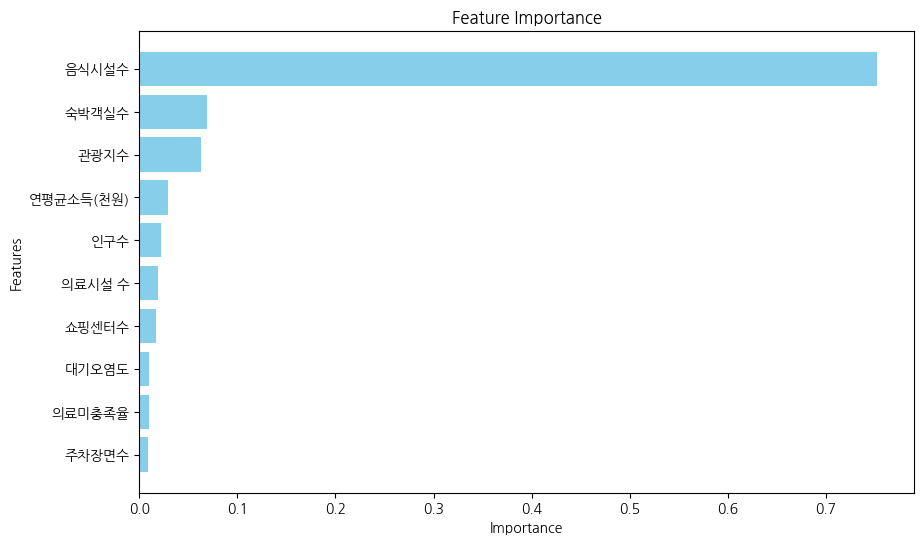

In [41]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=31)
model.fit(X_train, y_train)

# 변수 중요도 추출
importance = model.feature_importances_

# 중요도를 데이터프레임으로 정리
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 중요도 출력
display(feature_importance)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## 원본 데이터를 통해 남해군 특성 파악

In [42]:
data

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
0,강원특별자치도 강릉시,179318,472,5648,50,79.80,124.0,12817.0,35014.0,30.25,3374.0,7.4
1,강원특별자치도 고성군,21270,154,913,8,46.67,7.0,4960.0,31875.0,28.74,354.0,2.4
2,강원특별자치도 동해시,72280,126,2334,19,41.54,55.0,3345.0,35199.0,32.92,1303.0,3.6
3,강원특별자치도 삼척시,46205,201,1741,20,46.06,31.0,2534.0,33784.0,27.42,366.0,4.6
4,강원특별자치도 속초시,66912,145,3057,19,69.24,69.0,16188.0,34639.0,34.17,11648.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
242,충청북도 청주시 상당구,157184,231,4331,31,48.18,136.0,2356.0,36643.0,40.50,7.0,7.9
243,충청북도 청주시 서원구,172514,83,4108,31,42.22,136.0,813.0,36276.0,40.50,7.0,7.9
244,충청북도 청주시 청원구,168871,93,4521,47,53.54,136.0,4654.0,37929.0,40.50,7.0,7.9
245,충청북도 청주시 흥덕구,232581,95,6347,50,65.43,136.0,4706.0,39687.0,40.50,7.0,7.9


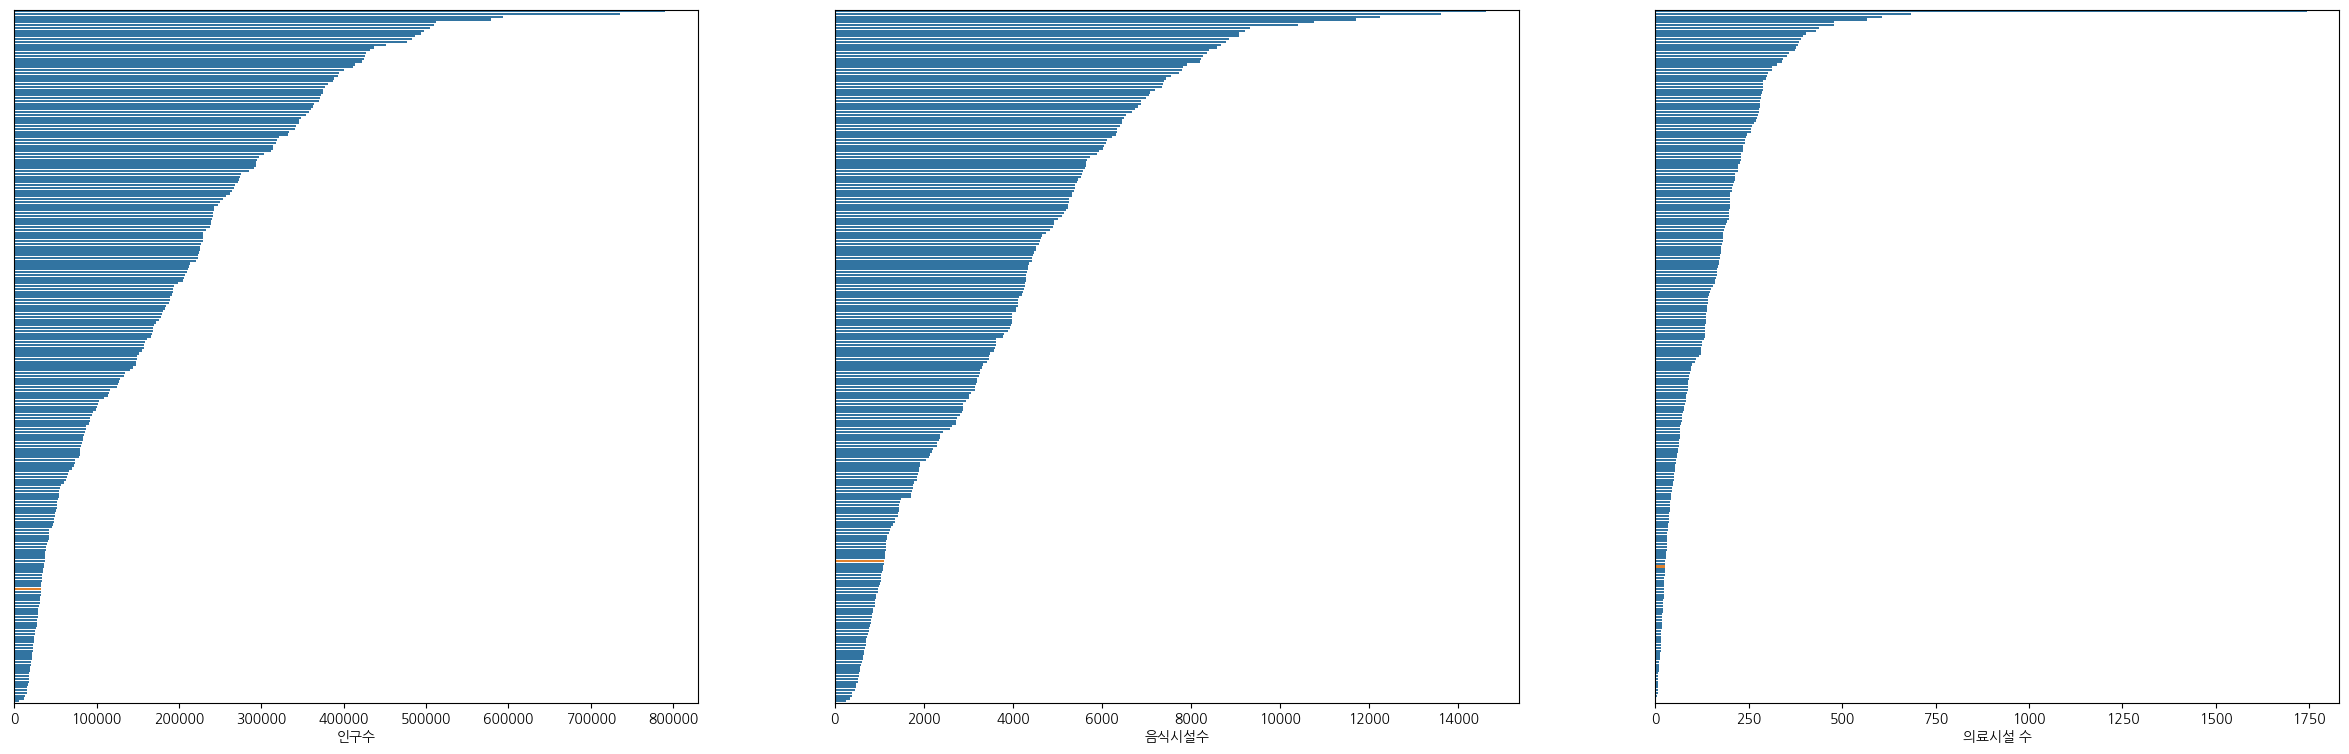

In [43]:
# 경상남도 남해군의 현재 확인
plt.figure(figsize=(30, 9))

# 인구 수
plt.subplot(1, 3, 1)
sns.barplot(
    data=data,
    x='인구수', y='지역명', orient='h',
    hue=data['지역명'] == '경상남도 남해군',
    order=data.sort_values(by='인구수', ascending=False)['지역명']
)
plt.yticks([])
plt.ylabel('')
plt.legend([], [], frameon=False)

# 음식시설 수
plt.subplot(1, 3, 2)
sns.barplot(
    data=data,
    x='음식시설수', y='지역명', orient='h',
    hue=data['지역명'] == '경상남도 남해군',
    order=data.sort_values(by='음식시설수', ascending=False)['지역명']
)
plt.yticks([])
plt.ylabel('')
plt.legend([], [], frameon=False)

# 인구당 음식시설 수
plt.subplot(1, 3, 3)
sns.barplot(
    data=data,
    x='의료시설 수', y='지역명', orient='h',
    hue=data['지역명'] == '경상남도 남해군',
    order=data.sort_values(by='의료시설 수', ascending=False)['지역명']
)
plt.yticks([])
plt.ylabel('')
plt.legend([], [], frameon=False)

# # 숙박시설 수
# plt.subplot(1, 6, 4)
# sns.barplot(
#     data=data,
#     x='숙박시설수', y='지역명', orient='h',
#     hue=data['지역명'] == '경상남도 남해군',
#     order=data.sort_values(by='숙박시설수', ascending=False)['지역명']
# )
# plt.yticks([])
# plt.ylabel('')
# plt.legend([], [], frameon=False)

# # 인구당 숙박시설 수
# plt.subplot(1, 6, 5)
# sns.barplot(
#     data=data,
#     x='인구당 숙박시설 수', y='지역명', orient='h',
#     hue=data['지역명'] == '경상남도 남해군',
#     order=data.sort_values(by='인구당 숙박시설 수', ascending=False)['지역명']
# )
# plt.yticks([])
# plt.ylabel('')
# plt.legend([], [], frameon=False)

# plt.subplot(1, 6, 6)
# sns.barplot(
#     data=data,
#     x='관광활성화 지수', y='지역명', orient='h',
#     hue=data['지역명'] == '경상남도 남해군',
#     order=data.sort_values(by='관광활성화 지수', ascending=False)['지역명']
# )
# plt.yticks([])
# plt.ylabel('')
# plt.legend([], [], frameon=False)

# # 그래프 간격 조정
# plt.subplots_adjust(wspace=0.4, hspace=0)
# plt.show()


In [44]:
# data.drop(['시군구명'], axis = 1).corr()

남해군의 인구수 대비 관광활성화 지수 순위: 247 개 중  [12] 위


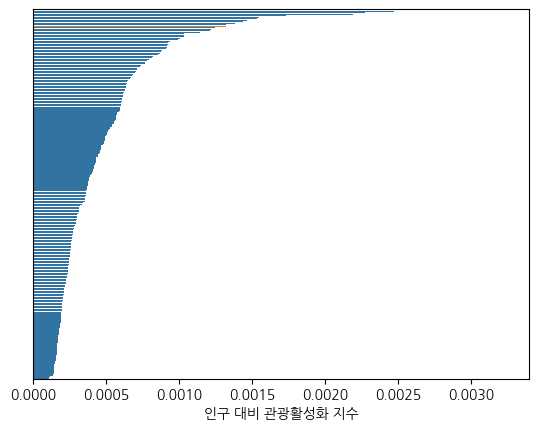

In [45]:
temp = data.copy()
temp['인구 대비 관광활성화 지수'] = temp['관광활성화 지수'] / temp['인구수']
temp2 = temp.sort_values(by='인구 대비 관광활성화 지수',ascending=False).reset_index()
print('남해군의 인구수 대비 관광활성화 지수 순위:', len(temp2), '개 중 ',temp2.loc[temp2['지역명']=='경상남도 남해군'].index.values + 1, '위')
sns.barplot(
    data=temp,
    x='인구 대비 관광활성화 지수',
    y='지역명', orient='h',
    hue=temp['지역명'] == '경상남도 남해군',
    order=temp.sort_values(by='인구 대비 관광활성화 지수', ascending=False)['지역명']
)
plt.yticks([])
plt.ylabel('')
plt.legend([], [], frameon=False)
plt.show()

In [46]:
# temp.sort_values(by='인구 대비 관광활성화 지수', ascending=False).head(10)

## 클러스터링, PCA


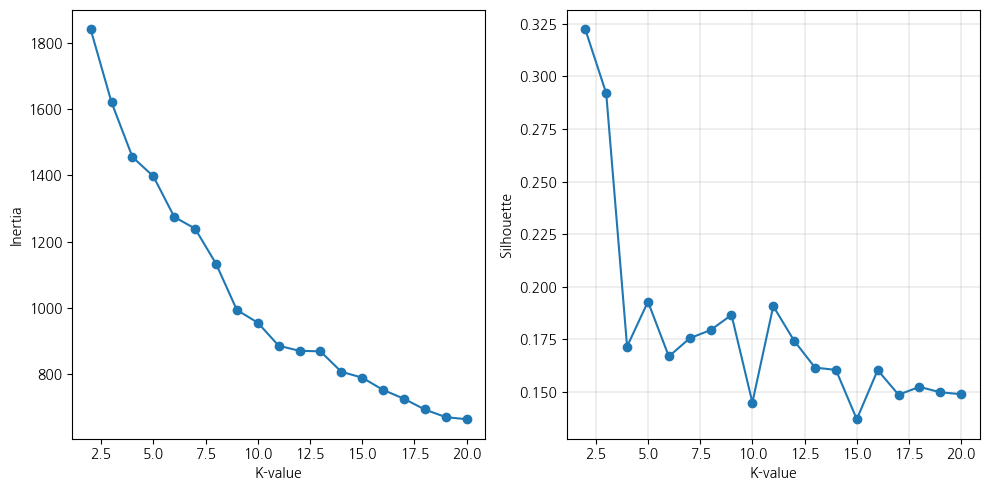

,k,Inertia,Silhouette
0,2,1841.621825,0.322207
1,3,1620.739102,0.291915
2,4,1455.655836,0.171645
3,5,1397.349070,0.192965
4,6,1274.686248,0.166933
5,7,1238.875429,0.175591
6,8,1132.882080,0.179470
7,9,992.808612,0.186659
8,10,954.475721,0.145072
9,11,884.819747,0.190818


In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# target 포함한 데이터 스케일링
data_sc = scaler.fit_transform(data.drop(columns=['지역명']))

# 남해군 여부 컬럼 추가 (후에 클러스터 확인용)
data['남해군여부'] = data['지역명'] == '경상남도 남해군'

# 실루엣 점수와 엘보우 메서드로 k값 도출
kvalue = range(2, 21)
ks = []
inertia = []
sil_score = []
for k in kvalue:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(data_sc)
    pred = model.predict(data_sc)
    ks.append(k)
    inertia.append(model.inertia_)
    sil_score.append(silhouette_score(data_sc, pred))

# 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(kvalue, inertia, marker='o')
plt.xlabel('K-value')
plt.ylabel('Inertia')
plt.subplot(1, 2, 2)
plt.plot(kvalue, sil_score, marker='o')
plt.xlabel('K-value')
plt.ylabel('Silhouette')
plt.grid(lw=0.3)
plt.tight_layout()
plt.show()

# 스코어 출력
result = pd.DataFrame({
    'k': ks,
    'Inertia': inertia,
    'Silhouette': sil_score
})
display(result)

In [48]:
temp = pd.DataFrame(data_sc)
temp

,0,1,2,3,4,5,6,7,8,9,10
0,0.001753,1.406912,0.680685,0.819075,1.366674,-0.133072,2.837159,-0.245715,-1.175797,0.288603,0.427528
1,-1.049463,-0.216500,-1.050600,-1.248845,-0.122535,-0.865576,0.476444,-0.954450,-1.505237,-0.773628,-1.196579
2,-0.710183,-0.359442,-0.531032,-0.707247,-0.353130,-0.565062,-0.008800,-0.203945,-0.593278,-0.439835,-0.806793
3,-0.883614,0.023438,-0.747854,-0.658011,-0.149954,-0.715319,-0.252473,-0.523429,-1.793224,-0.769408,-0.481972
4,-0.745887,-0.262446,-0.266677,-0.707247,0.891997,-0.477412,3.850011,-0.330384,-0.320563,3.198834,-1.001686
...,...,...,...,...,...,...,...,...,...,...,...
242,-0.145466,0.176590,0.199143,-0.116413,-0.054659,-0.057943,-0.305955,0.122087,1.060466,-0.895679,0.589939
243,-0.043502,-0.578960,0.117606,-0.116413,-0.322564,-0.057943,-0.769565,0.039224,1.060466,-0.895679,0.589939
244,-0.067732,-0.527910,0.268613,0.671366,0.186275,-0.057943,0.384503,0.412445,1.060466,-0.895679,0.589939
245,0.356018,-0.517700,0.936264,0.819075,0.720736,-0.057943,0.400127,0.809372,1.060466,-0.895679,0.589939


남해군 클러스터 번호: 4
남해군과 유사한 지역:
['강원특별자치도 영월군' '강원특별자치도 인제군' '강원특별자치도 평창군' '경기도 가평군' '경기도 과천시' '경기도 구리시'
 '경기도 동두천시' '경기도 양평군' '경기도 여주시' '경기도 의왕시' '경기도 포천시' '경상남도 남해군' '경상남도 사천시'
 '경상남도 창원시 마산합포구' '경상남도 창원시 마산회원구' '경상남도 창원시 의창구' '경상남도 창원시 진해구'
 '경상남도 통영시' '경상남도 함안군' '경상북도 경산시' '경상북도 김천시' '경상북도 성주군' '경상북도 안동시'
 '경상북도 영주시' '경상북도 영천시' '경상북도 칠곡군' '대구광역시 남구' '대구광역시 중구' '대전광역시 중구'
 '부산광역시 기장군' '부산광역시 북구' '부산광역시 사상구' '부산광역시 사하구' '부산광역시 수영구' '부산광역시 연제구'
 '부산광역시 영도구' '서울특별시 금천구' '울산광역시 동구' '울산광역시 중구' '인천광역시 계양구' '인천광역시 옹진군'
 '전라남도 광양시' '전라남도 나주시' '전라남도 담양군' '전라남도 무안군' '전북특별자치도 고창군' '전북특별자치도 김제시'
 '전북특별자치도 남원시' '전북특별자치도 부안군' '전북특별자치도 장수군' '전북특별자치도 정읍시' '충청남도 공주시'
 '충청남도 논산시' '충청남도 보령시' '충청남도 서산시' '충청남도 예산군' '충청남도 태안군' '충청남도 홍성군'
 '충청북도 괴산군' '충청북도 보은군' '충청북도 음성군' '충청북도 제천시' '충청북도 증평군' '충청북도 진천군'
 '충청북도 청주시 상당구' '충청북도 청주시 서원구']


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


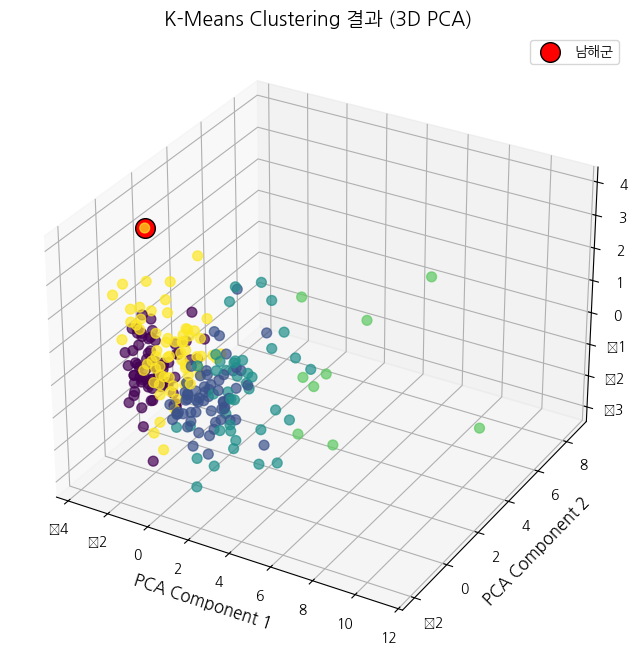

In [49]:
# 3차원

# K-Means 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
data['클러스터'] = kmeans.fit_predict(data_sc)

# 클러스터링 결과 확인
# 남해군과 동일한 클러스터에 속한 지역 필터링
남해군_클러스터 = data.loc[data['지역명'] == '경상남도 남해군', '클러스터'].iloc[0]
similar_regions = data[data['클러스터'] == 남해군_클러스터]

# 결과 출력
print(f"남해군 클러스터 번호: {남해군_클러스터}")
print("남해군과 유사한 지역:")
print(similar_regions['지역명'].values)

# 클러스터 3차원 시각화
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 1. PCA를 사용하여 데이터 차원 축소 (3차원)
pca = PCA(n_components=3)
data_pca_3d = pca.fit_transform(data_sc)  # data_sc는 스케일링된 데이터

# 2. 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 클러스터링 결과 플롯
scatter = ax.scatter(
    data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2],
    c=data['클러스터'], cmap='viridis', s=50, alpha=0.7
)

# 남해군 강조
남해군_idx = data[data['지역명'] == '경상남도 남해군'].index[0]
ax.scatter(
    data_pca_3d[남해군_idx, 0], data_pca_3d[남해군_idx, 1], data_pca_3d[남해군_idx, 2],
    color='red', s=200, label='남해군', edgecolor='black'
)

# 축 및 제목 설정
ax.set_title("K-Means Clustering 결과 (3D PCA)", fontsize=14)
ax.set_xlabel("PCA Component 1", fontsize=12)
ax.set_ylabel("PCA Component 2", fontsize=12)
ax.set_zlabel("PCA Component 3", fontsize=12)

# 범례 추가
plt.legend()

# 3. 회전 애니메이션 함수
def update(frame):
    ax.view_init(elev=20, azim=frame)  # 회전 각도 조정 (elev: 높이, azim: 회전)
    return fig,

# 애니메이션 생성
ani = FuncAnimation(fig, update, frames=range(0, 360, 2), interval=50, blit=False)

# 그래프 출력
plt.show()


###################################################

# # 2차원

# # K-Means 클러스터링
# kmeans = KMeans(n_clusters=5, random_state=42)
# data['클러스터'] = kmeans.fit_predict(data_sc)

# # 클러스터링 결과 확인
# # 남해군과 동일한 클러스터에 속한 지역 필터링
# 남해군_클러스터 = data.loc[data['지역명'] == '경상남도 남해군', '클러스터'].iloc[0]
# similar_regions = data[data['클러스터'] == 남해군_클러스터]

# # 결과 출력
# print(f"남해군 클러스터 번호: {남해군_클러스터}")
# print("남해군과 유사한 지역:")
# print(similar_regions['지역명'].values)

# # 클러스터 2차원 시각화
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # 1. PCA를 사용하여 데이터 차원 축소 (2차원)
# pca = PCA(n_components=2)
# data_pca_2d = pca.fit_transform(data_sc)  # data_sc는 스케일링된 데이터

# # 2. 2D 시각화
# fig, ax = plt.subplots(figsize=(10, 8))

# # 클러스터링 결과 플롯
# scatter = ax.scatter(
#     data_pca_2d[:, 0], data_pca_2d[:, 1],
#     c=data['클러스터'], cmap='viridis', s=50, alpha=0.7
# )

# # 남해군 강조
# 남해군_idx = data[data['지역명'] == '경상남도 남해군'].index[0]
# ax.scatter(
#     data_pca_2d[남해군_idx, 0], data_pca_2d[남해군_idx, 1],
#     color='red', s=200, label='남해군', edgecolor='black'
# )

# # 축 및 제목 설정
# ax.set_title("K-Means Clustering 결과 (2D PCA)", fontsize=14)
# ax.set_xlabel("PCA Component 1", fontsize=12)
# ax.set_ylabel("PCA Component 2", fontsize=12)

# # 범례 추가
# plt.legend()

# # 그래프 출력
# plt.show()


In [50]:
# 애니메이션 저장
#ani.save('kmeans_animation.gif', writer='imagemagick')

<ipython-input-50-5beeb5a5eb9f>:2: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  ani.save('kmeans_animation.gif', writer='imagemagick')


KeyboardInterrupt: 

In [51]:
data.drop('지역명', axis=1).corr()

,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율,남해군여부,클러스터
인구수,1.000000,0.205442,0.907618,0.781141,0.774943,0.774995,0.273472,0.507973,0.450241,0.272561,-0.028821,-0.062107,0.090628
관광지수,0.205442,1.000000,0.383740,0.195909,0.475897,0.414472,0.578204,0.312381,0.052988,0.054978,-0.094377,0.001494,0.164529
음식시설수,0.907618,0.383740,1.000000,0.808002,0.839001,0.798487,0.494790,0.488950,0.370957,0.260224,0.010456,-0.062461,0.169150
쇼핑센터수,0.781141,0.195909,0.808002,1.000000,0.673183,0.567348,0.303939,0.384201,0.418340,0.318613,0.099471,-0.023118,0.142149
관광활성화 지수,0.774943,0.475897,0.839001,0.673183,1.000000,0.645045,0.621923,0.545409,0.388746,0.317690,-0.048426,-0.017987,0.206883
의료시설 수,0.774995,0.414472,0.798487,0.567348,0.645045,1.000000,0.325432,0.599217,0.296598,0.170310,-0.107978,-0.048002,0.113878
숙박객실수,0.273472,0.578204,0.494790,0.303939,0.621923,0.325432,1.000000,0.220277,0.075683,0.238958,-0.034383,-0.025235,0.158909
연평균소득(천원),0.507973,0.312381,0.488950,0.384201,0.545409,0.599217,0.220277,1.000000,0.300051,0.191215,-0.152107,-0.061343,0.120895
대기오염도,0.450241,0.052988,0.370957,0.418340,0.388746,0.296598,0.075683,0.300051,1.000000,0.283997,-0.032312,-0.117809,0.205888
주차장면수,0.272561,0.054978,0.260224,0.318613,0.317690,0.170310,0.238958,0.191215,0.283997,1.000000,-0.088764,-0.029411,0.097650


In [52]:
data.columns

Index(['지역명', '인구수', '관광지수', '음식시설수', '쇼핑센터수', '관광활성화 지수', '의료시설 수', '숙박객실수',
       '연평균소득(천원)', '대기오염도', '주차장면수', '의료미충족율', '남해군여부', '클러스터'],
      dtype='object')

In [53]:
data.columns.values

array(['지역명', '인구수', '관광지수', '음식시설수', '쇼핑센터수', '관광활성화 지수', '의료시설 수',
       '숙박객실수', '연평균소득(천원)', '대기오염도', '주차장면수', '의료미충족율', '남해군여부', '클러스터'],
      dtype=object)

In [54]:
data_sc.shape

(247, 11)

PCA 주성분 계수 (loading matrix):


,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율
PCA1,0.390774,0.214979,0.412410,0.352634,0.397926,0.363337,0.245152,0.284388,0.215254,0.167631,-0.029611
PCA2,-0.240847,0.609545,-0.048327,-0.259821,0.102568,0.015316,0.518348,0.019783,-0.394066,-0.153272,-0.204925
PCA3,0.036273,0.053073,0.145593,0.185024,0.058576,-0.051328,0.159845,-0.280587,-0.201193,-0.278143,0.843948


<ipython-input-55-4009f2c315e1>:29: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


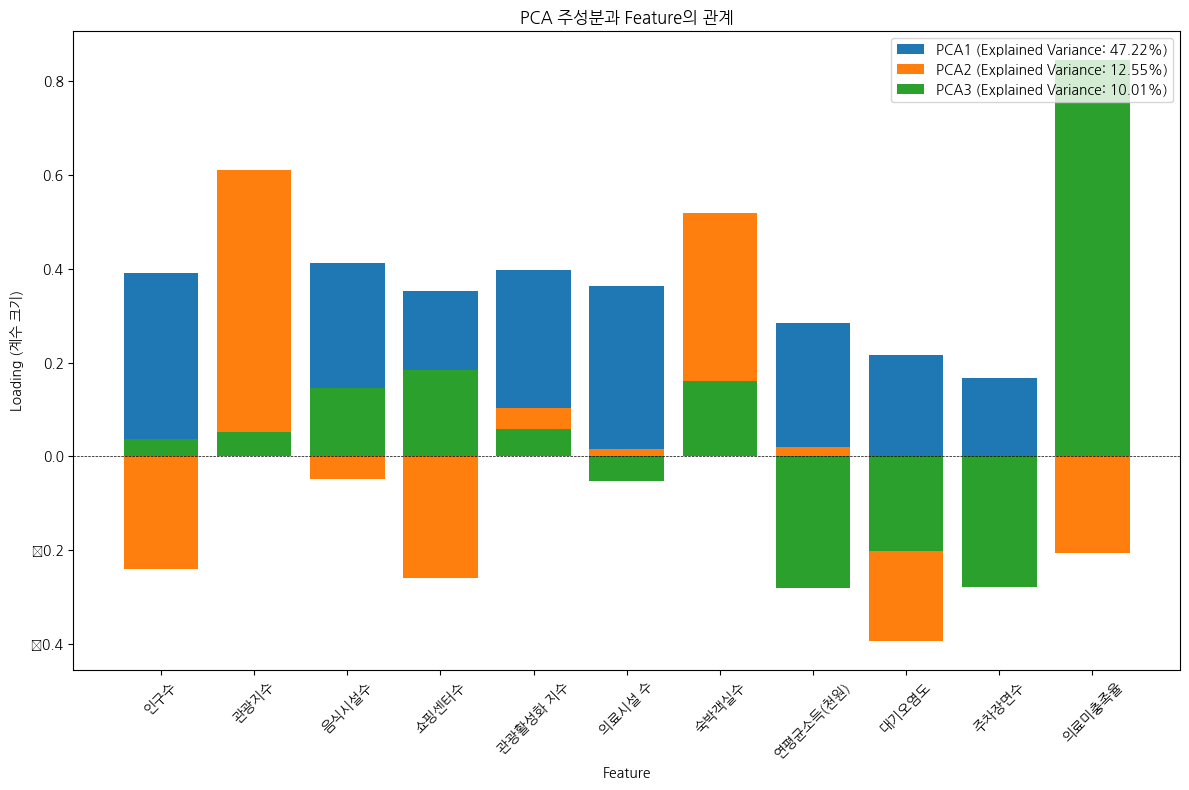

In [55]:
# PCA 의미분석

# 1. 주성분 계수 (loading matrix) 추출
loading_matrix = pd.DataFrame(
    pca.components_,
    columns = ['인구수', '관광지수', '음식시설수', '쇼핑센터수', '관광활성화 지수', '의료시설 수',
       '숙박객실수', '연평균소득(천원)', '대기오염도', '주차장면수', '의료미충족율'],
    index=['PCA1', 'PCA2', 'PCA3']  # 3차원일때
    # index=['PAC1', 'PCA2'] # 2차원일때
)
# 주성분 계수 출력
print("PCA 주성분 계수 (loading matrix):")
display(loading_matrix)

# 2. 주성분 별 주요 Feature 시각화
plt.figure(figsize=(12, 8))
for i, component in enumerate(loading_matrix.index):
    plt.bar(
        loading_matrix.columns, loading_matrix.loc[component],
        label=f'{component} (Explained Variance: {pca.explained_variance_ratio_[i]:.2%})'
    )
    plt.xticks(rotation=45, fontsize=10)

plt.title("PCA 주성분과 Feature의 관계")
plt.xlabel("Feature")
plt.ylabel("Loading (계수 크기)")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [56]:
data[data['지역명'] == '경상남도 남해군']

,지역명,인구수,관광지수,음식시설수,쇼핑센터수,관광활성화 지수,의료시설 수,숙박객실수,연평균소득(천원),대기오염도,주차장면수,의료미충족율,남해군여부,클러스터
64,경상남도 남해군,32600,201,1107,26,43.12,25.0,2057.0,31841.0,27.17,1242.0,18.7,True,4


<ipython-input-57-ef8c6604bbca>:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


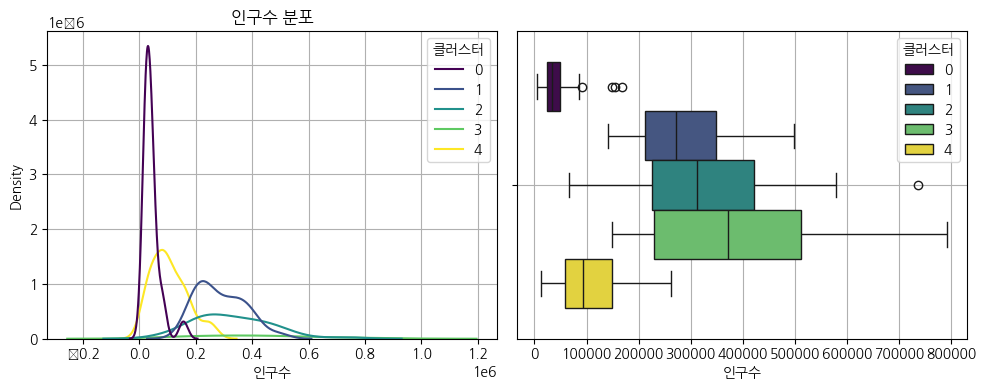

<ipython-input-57-ef8c6604bbca>:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


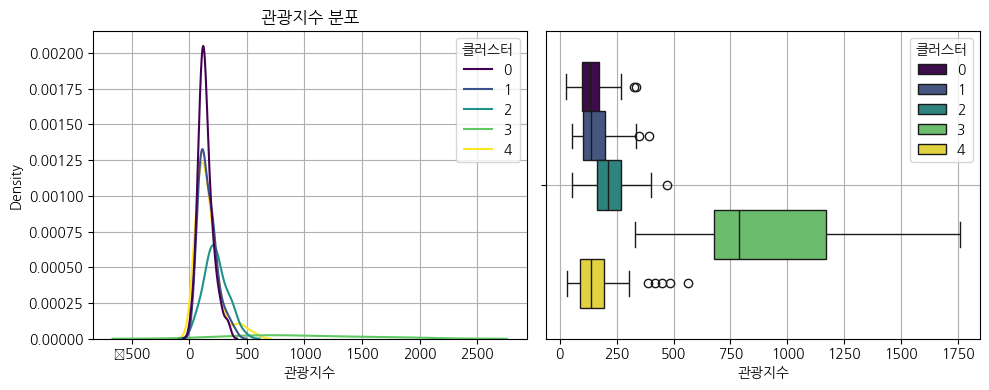

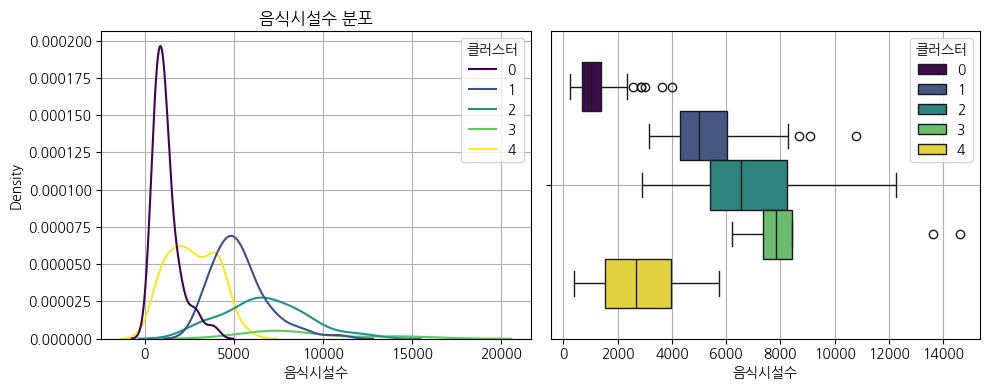

<ipython-input-57-ef8c6604bbca>:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


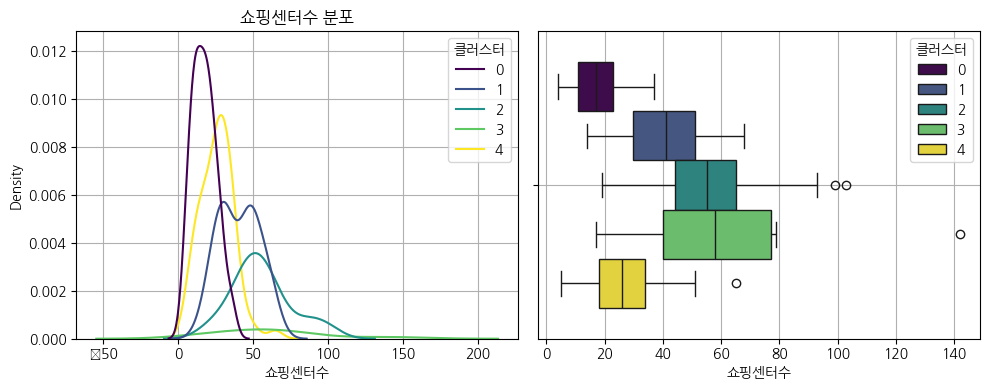

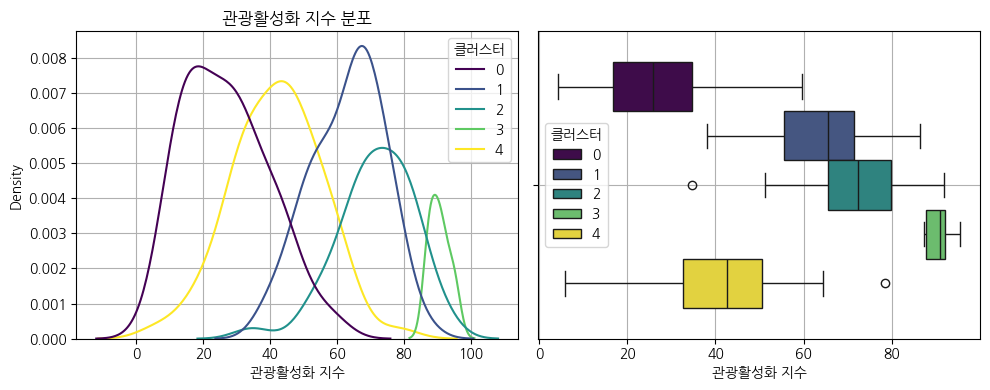

<ipython-input-57-ef8c6604bbca>:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


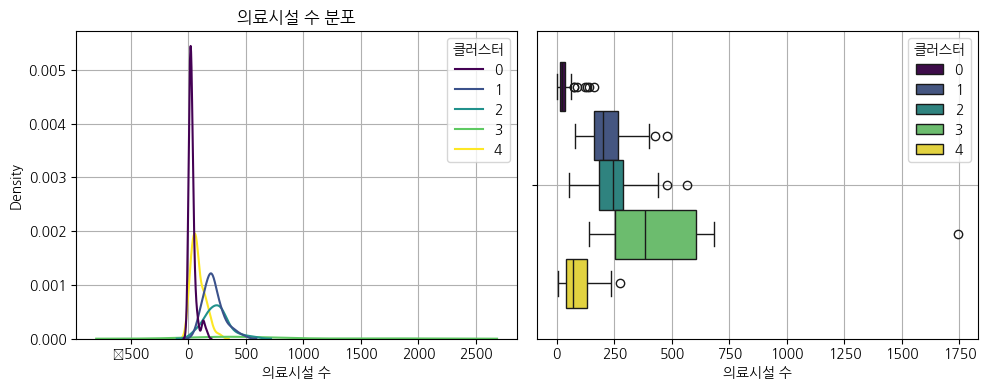

<ipython-input-57-ef8c6604bbca>:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


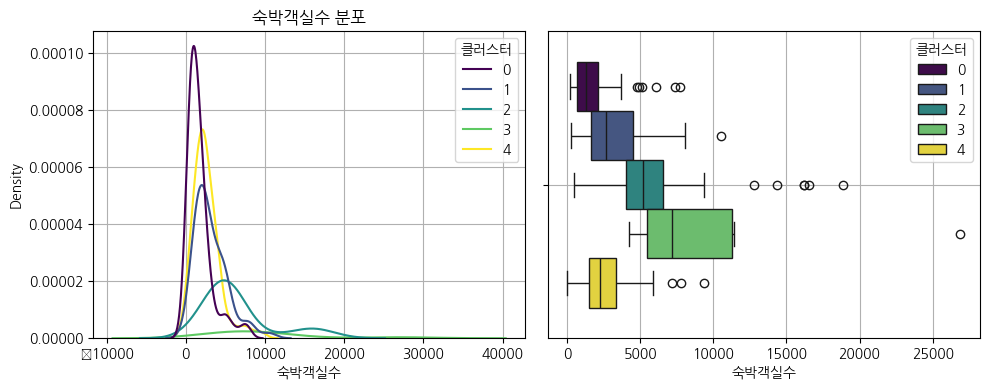

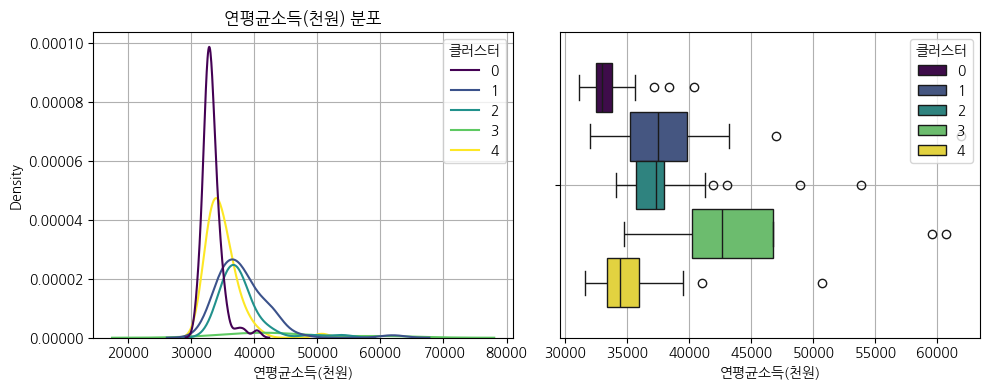

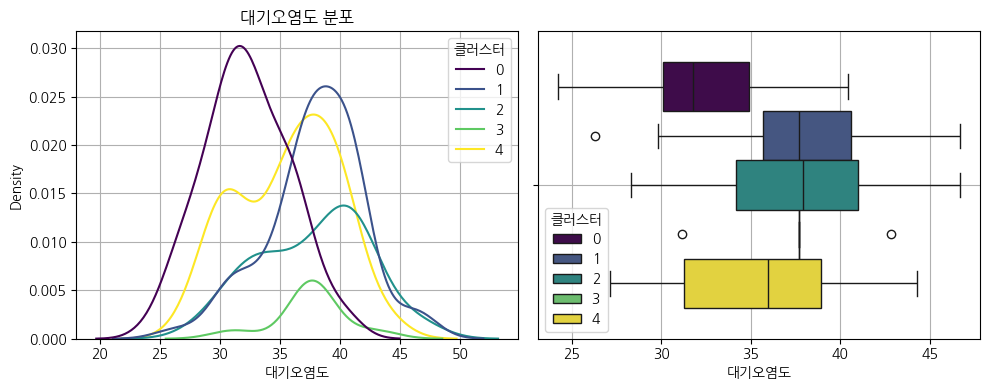

<ipython-input-57-ef8c6604bbca>:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


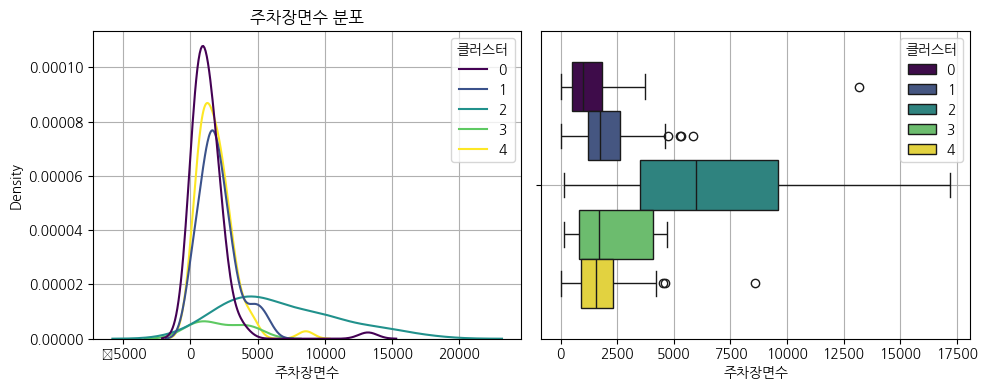

In [57]:
# 클러스터별 컬럼 분포
for col in ['인구수', '관광지수', '음식시설수', '쇼핑센터수', '관광활성화 지수', '의료시설 수',
       '숙박객실수', '연평균소득(천원)', '대기오염도', '주차장면수']:
  feature = col

  plt.figure(figsize=(10,4))
  plt.subplot(1, 2, 1)
  sns.kdeplot(x= feature, data = data, hue='클러스터', palette='viridis')
  plt.title(f'{feature} 분포')
  plt.grid()

  plt.subplot(1,2,2)
  sns.boxplot( x= feature, data = data, hue = '클러스터', palette='viridis')
  plt.grid()

  plt.tight_layout()
  plt.show()